In [1]:
from qiskit import Aer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import SpinMapper, DirectMapper, LinearMapper, JordanWignerMapper
from qiskit.opflow import X, Y, Z, I
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory

from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit

import pylab
import numpy as np
import retworkx as rx
from qiskit_nature.problems.second_quantization.lattice import (
    BoundaryCondition,
    IsingModel,
    FermiHubbardModel,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

from matplotlib.pyplot import figure
import time

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


In [2]:
def findGroundState(pauliSumOp):
    return min(np.linalg.eigh(pauliSumOp.to_matrix())[0])

#Converts SpinOp to PauliSumOp
def convertSpin(ham):
    result = None
    spins = [I, Z, Y, X]
    for c, x, y, z in zip(ham._coeffs, ham.x, ham.y, ham.z):
        spin = x * 3 + y * 2 + z
        pauli = spins[spin[0]]
        for n in range(1, ham.register_length):
            pauli ^= spins[spin[n]]
        pauli *= c
        result = result + pauli if result else pauli
    return result

def makeLatticeIsing(size, cx):
    lattice = LineLattice(size, boundary_condition=BoundaryCondition.PERIODIC)

    t = -1.0  # the interaction parameter corresponds to Z
    v = cx  # the onsite potential corresponds to X

    ising = IsingModel.uniform_parameters(
        lattice=lattice,
        uniform_interaction=t, #interaction strength -- "hopping term"
        uniform_onsite_potential=v
    )
    return convertSpin(ising.second_q_ops())

def makeAnsatz(reps = 1, skip = True):
    return TwoLocal(
            rotation_blocks=["rx"],
            entanglement_blocks="rzz",
            entanglement="circular",
            skip_final_rotation_layer = skip,
            reps = reps,
            parameter_prefix="y",)

def findMin(ansatz, reps, cx):
    vqe_solver = VQE(
    ansatz = ansatz,
    quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector")),)
    
    results = np.full(n, None)
    groundStates = np.full(n, 9999.9)
    times = np.full([n, reps], 0.0)
    for i in range(1, n):
        ising = makeLatticeIsing(i, cx)
        if ising:
            for j in range(reps):
                    result = vqe_solver.compute_minimum_eigenvalue(ising)
                    val = np.real(result.eigenvalue)
                    times[i][j]= result.optimizer_time
                    if val < np.real(groundStates[i]):
                        results[i] = result
                        groundStates[i] = val
                        print(f"Minimum   {i:>2}: {np.round(np.real(result.eigenvalue), 3):<7} " +
                              f"time: {round(result.optimizer_time, 2)}")
                    else:
                        print(f"Processed {i:>2}          time: {round(result.optimizer_time, 2)}")
    return results, groundStates, times

In [3]:
# define maximum size of system
n = 12
#define number of repetitions
r = 11
# Number of x-samples we have
s = 41

samples = [round(-2.0 + (4 * j/(s-1)), 5) for j in range(s)]
print(samples)

[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]


In [4]:
# Find True Groundstates of Model
trueGroundStates = np.full([s,n], 0.0)
trueTimes = np.full([s,n], 0.0)
for i, cx in enumerate(samples):
    print(f"X = {cx}:")
    for j in range(1, n):
        t1_start = time.time()
        trueGroundStates[i][j] = findGroundState(makeLatticeIsing(j, cx))
        trueTimes[i][j] =  time.time() - t1_start
        print(f"{j:>10}: {round(trueGroundStates[i][j],3):<7} time: {round(trueTimes[i][j],3)}")

X = -2.0:
         1: -2.0    time: 0.002
         2: -4.123  time: 0.004
         3: -6.464  time: 0.008
         4: -8.543  time: 0.012
         5: -10.651 time: 0.014
         6: -12.769 time: 0.018
         7: -14.893 time: 0.021
         8: -17.018 time: 0.03
         9: -19.144 time: 0.072
        10: -21.271 time: 0.301
        11: -23.398 time: 2.426
X = -1.9:
         1: -1.9    time: 0.001
         2: -3.929  time: 0.004
         3: -6.192  time: 0.011
         4: -8.176  time: 0.011
         5: -10.189 time: 0.013
         6: -12.213 time: 0.019
         7: -14.242 time: 0.026
         8: -16.274 time: 0.035
         9: -18.307 time: 0.107
        10: -20.341 time: 0.356
        11: -22.375 time: 2.527
X = -1.8:
         1: -1.8    time: 0.001
         2: -3.736  time: 0.003
         3: -5.924  time: 0.008
         4: -7.813  time: 0.01
         5: -9.731  time: 0.013
         6: -11.662 time: 0.015
         7: -13.598 time: 0.02
         8: -15.537 time: 0.031
         9: -

         9: -9.09   time: 0.119
        10: -10.1   time: 0.514
        11: -11.11  time: 4.643
X = 0.3:
         1: -0.3    time: 0.001
         2: -1.166  time: 0.004
         3: -3.078  time: 0.011
         4: -4.093  time: 0.014
         5: -5.114  time: 0.015
         6: -6.136  time: 0.019
         7: -7.158  time: 0.026
         8: -8.181  time: 0.036
         9: -9.204  time: 0.109
        10: -10.226 time: 0.544
        11: -11.249 time: 4.554
X = 0.4:
         1: -0.4    time: 0.001
         2: -1.281  time: 0.005
         3: -3.144  time: 0.01
         4: -4.169  time: 0.01
         5: -5.205  time: 0.015
         6: -6.243  time: 0.016
         7: -7.283  time: 0.024
         8: -8.323  time: 0.038
         9: -9.364  time: 0.118
        10: -10.404 time: 0.571
        11: -11.445 time: 4.573
X = 0.5:
         1: -0.5    time: 0.001
         2: -1.414  time: 0.004
         3: -3.232  time: 0.009
         4: -4.272  time: 0.012
         5: -5.325  time: 0.014
         6: -6.

In [5]:
results = [None] * s
groundStates = [None] * s
times = [None] * s
print(groundStates)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [6]:
ansatz = makeAnsatz()
for i, cx in enumerate(samples):
    print(f"X = {cx}:")
    results[i], groundStates[i], times[i] = findMin(ansatz, r, cx)

X = -2.0:
Minimum    1: 0.0     time: 0.22
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -2.562  time: 0.14
Processed  2          time: 0.13
Minimum    2: -2.562  time: 0.19
Processed  2          time: 0.19
Minimum    2: -2.562  time: 0.17
Processed  2          time: 0.1
Processed  2          time: 0.14
Processed  2          time: 0.23
Processed  2          time: 0.17
Processed  2          time: 0.14
Processed  2          time: 0.13
Minimum    3: -4.854  time: 0.43
Minimum    3: -4.854  time: 0.41
Processed  3          time: 0.31
Processed  3          time: 0.57
Processed  3          time: 0.38
Processed  3          time: 0.45
Processed  3          time: 0.39
Processed  3          time: 0.37
P

Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -2.368  time: 0.08
Minimum    2: -2.368  time: 0.11
Minimum    2: -2.368  time: 0.17
Processed  2          time: 0.09
Processed  2          time: 0.13
Minimum    2: -2.368  time: 0.11
Processed  2          time: 0.1
Processed  2          time: 0.08
Processed  2          time: 0.09
Processed  2          time: 0.07
Processed  2          time: 0.09
Minimum    3: -4.589  time: 0.48
Minimum    3: -4.589  time: 0.35
Minimum    3: -4.589  time: 0.41
Processed  3          time: 0.4
Processed  3          time: 0.23
Processed  3          time: 0.5
Processed  3          time: 0.28
Processed  3          time: 0.43
Processed  3          time: 0.41
Processed  3          time: 0.27
Processed  3          time: 0.33
Minimum    4: -6.118  time: 0.37
Minimum    4: -6.118  time: 0.75
Processed  4          time: 0.41
Minimum    4:

Minimum    2: -2.176  time: 0.12
Processed  2          time: 0.17
Processed  2          time: 0.17
Processed  2          time: 0.11
Processed  2          time: 0.1
Processed  2          time: 0.16
Minimum    2: -2.176  time: 0.11
Processed  2          time: 0.14
Processed  2          time: 0.14
Processed  2          time: 0.13
Minimum    3: -4.33   time: 0.34
Processed  3          time: 0.66
Minimum    3: -4.33   time: 0.4
Processed  3          time: 0.67
Minimum    3: -4.33   time: 0.41
Processed  3          time: 0.61
Processed  3          time: 0.53
Processed  3          time: 0.55
Processed  3          time: 0.5
Processed  3          time: 0.41
Processed  3          time: 0.44
Minimum    4: -5.774  time: 0.47
Minimum    4: -5.774  time: 0.71
Minimum    4: -5.774  time: 0.52
Processed  4          time: 0.7
Processed  4          time: 0.44
Processed  4          time: 0.59
Processed  4          time: 0.59
Processed  4          time: 1.45
Processed  4          time: 0.67
Minimum    4: 

Processed  2          time: 0.19
Processed  2          time: 0.15
Processed  2          time: 0.16
Minimum    3: -4.081  time: 0.41
Processed  3          time: 0.48
Minimum    3: -4.081  time: 0.65
Processed  3          time: 0.42
Processed  3          time: 0.45
Minimum    3: -4.081  time: 0.4
Processed  3          time: 0.46
Processed  3          time: 0.4
Processed  3          time: 0.43
Processed  3          time: 0.71
Processed  3          time: 0.66
Minimum    4: -2.8    time: 0.76
Minimum    4: -5.441  time: 0.47
Processed  4          time: 0.76
Processed  4          time: 0.62
Processed  4          time: 0.75
Minimum    4: -5.441  time: 0.79
Minimum    4: -5.441  time: 0.73
Processed  4          time: 0.77
Minimum    4: -5.441  time: 0.72
Processed  4          time: 0.59
Processed  4          time: 0.67
Minimum    5: -6.801  time: 1.49
Processed  5          time: 1.53
Processed  5          time: 1.02
Minimum    5: -6.801  time: 1.2
Processed  5          time: 1.02
Processed  5 

Processed  3          time: 0.4
Minimum    3: -3.843  time: 0.41
Minimum    3: -3.843  time: 0.41
Processed  3          time: 0.69
Minimum    3: -3.843  time: 0.53
Processed  3          time: 0.54
Processed  3          time: 0.67
Processed  3          time: 0.39
Processed  3          time: 0.37
Minimum    4: -5.124  time: 0.56
Minimum    4: -5.124  time: 1.18
Processed  4          time: 0.59
Minimum    4: -5.124  time: 0.63
Processed  4          time: 0.78
Processed  4          time: 0.65
Processed  4          time: 0.6
Minimum    4: -5.124  time: 0.6
Processed  4          time: 0.83
Processed  4          time: 0.47
Processed  4          time: 0.79
Minimum    5: -6.405  time: 1.46
Processed  5          time: 1.22
Processed  5          time: 1.12
Minimum    5: -6.405  time: 1.49
Processed  5          time: 1.33
Processed  5          time: 1.07
Processed  5          time: 1.19
Minimum    5: -6.405  time: 1.19
Minimum    5: -6.405  time: 1.21
Processed  5          time: 1.44
Processed  5 

Processed  3          time: 0.49
Minimum    3: -3.621  time: 0.69
Processed  3          time: 0.51
Processed  3          time: 0.56
Minimum    4: -4.828  time: 0.84
Minimum    4: -4.828  time: 0.89
Processed  4          time: 0.57
Minimum    4: -4.828  time: 0.59
Processed  4          time: 0.95
Processed  4          time: 0.75
Processed  4          time: 0.75
Processed  4          time: 0.46
Processed  4          time: 0.71
Processed  4          time: 0.49
Processed  4          time: 0.96
Minimum    5: -3.644  time: 0.97
Minimum    5: -6.036  time: 1.18
Processed  5          time: 0.94
Minimum    5: -6.036  time: 1.53
Processed  5          time: 0.79
Processed  5          time: 1.19
Processed  5          time: 1.1
Processed  5          time: 1.03
Processed  5          time: 1.12
Processed  5          time: 0.84
Minimum    5: -6.036  time: 1.15
Minimum    6: -7.243  time: 1.24
Processed  6          time: 1.25
Processed  6          time: 1.63
Processed  6          time: 1.61
Processed  

Processed  4          time: 0.63
Minimum    4: -4.561  time: 0.78
Processed  4          time: 1.54
Processed  4          time: 0.74
Processed  4          time: 0.62
Minimum    4: -4.561  time: 0.77
Processed  4          time: 0.91
Minimum    4: -4.561  time: 0.91
Processed  4          time: 1.3
Minimum    5: -5.702  time: 1.35
Processed  5          time: 1.15
Minimum    5: -5.702  time: 1.3
Processed  5          time: 1.13
Minimum    5: -5.702  time: 2.09
Processed  5          time: 0.86
Processed  5          time: 1.1
Processed  5          time: 1.52
Processed  5          time: 1.02
Processed  5          time: 1.43
Processed  5          time: 1.24
Minimum    6: -4.273  time: 1.27
Minimum    6: -6.842  time: 1.46
Processed  6          time: 1.39
Processed  6          time: 1.22
Processed  6          time: 1.69
Processed  6          time: 1.07
Processed  6          time: 1.09
Processed  6          time: 2.18
Processed  6          time: 1.33
Processed  6          time: 1.1
Processed  6  

Processed  4          time: 0.58
Processed  4          time: 0.47
Processed  4          time: 0.59
Processed  4          time: 0.4
Minimum    5: -2.5    time: 1.25
Minimum    5: -5.415  time: 0.79
Processed  5          time: 0.91
Minimum    5: -5.415  time: 1.11
Minimum    5: -5.415  time: 1.29
Minimum    5: -5.415  time: 1.08
Processed  5          time: 0.95
Processed  5          time: 0.97
Processed  5          time: 0.65
Processed  5          time: 1.52
Processed  5          time: 0.94
Minimum    6: -3.602  time: 0.81
Minimum    6: -3.602  time: 1.43
Minimum    6: -6.499  time: 0.72
Processed  6          time: 0.64
Processed  6          time: 1.5
Processed  6          time: 1.03
Processed  6          time: 1.17
Processed  6          time: 2.12
Processed  6          time: 1.01
Processed  6          time: 1.09
Processed  6          time: 1.29
Minimum    7: -4.691  time: 2.27
Minimum    7: -7.582  time: 1.89
Processed  7          time: 2.81
Minimum    7: -7.582  time: 2.43
Processed  7

Minimum    5: -5.193  time: 2.08
Processed  5          time: 1.17
Processed  5          time: 1.58
Processed  5          time: 2.3
Processed  5          time: 1.47
Processed  5          time: 1.58
Processed  5          time: 1.22
Processed  5          time: 1.53
Processed  5          time: 1.65
Processed  5          time: 1.11
Minimum    6: -6.231  time: 2.08
Minimum    6: -6.231  time: 2.44
Processed  6          time: 1.34
Processed  6          time: 2.46
Processed  6          time: 1.39
Processed  6          time: 2.15
Processed  6          time: 1.35
Processed  6          time: 2.21
Processed  6          time: 1.23
Processed  6          time: 1.79
Processed  6          time: 2.31
Minimum    7: -4.036  time: 2.81
Minimum    7: -7.27   time: 2.66
Processed  7          time: 3.01
Processed  7          time: 3.79
Minimum    7: -7.27   time: 4.52
Processed  7          time: 3.54
Processed  7          time: 2.36
Processed  7          time: 4.57
Processed  7          time: 4.36
Processed  

Processed  5          time: 1.62
Processed  5          time: 2.2
Processed  5          time: 1.9
Processed  5          time: 2.09
Processed  5          time: 3.28
Minimum    6: -6.059  time: 2.71
Minimum    6: -6.059  time: 2.64
Processed  6          time: 2.4
Processed  6          time: 2.29
Processed  6          time: 2.76
Processed  6          time: 2.16
Processed  6          time: 2.33
Processed  6          time: 2.59
Processed  6          time: 1.8
Processed  6          time: 2.51
Processed  6          time: 2.57
Minimum    7: -7.069  time: 3.5
Processed  7          time: 3.88
Minimum    7: -7.069  time: 4.36
Processed  7          time: 4.16
Processed  7          time: 2.86
Processed  7          time: 3.91
Processed  7          time: 5.27
Processed  7          time: 4.23
Processed  7          time: 3.45
Minimum    7: -7.069  time: 4.98
Processed  7          time: 3.99
Minimum    8: -4.452  time: 5.34
Minimum    8: -8.079  time: 5.11
Processed  8          time: 5.85
Processed  8   

Minimum    6: -6.0    time: 0.66
Processed  6          time: 0.69
Minimum    6: -6.0    time: 1.51
Processed  6          time: 0.51
Processed  6          time: 0.65
Processed  6          time: 0.86
Processed  6          time: 0.59
Processed  6          time: 1.58
Processed  6          time: 0.78
Minimum    6: -6.0    time: 0.96
Processed  6          time: 1.4
Minimum    7: -7.0    time: 0.73
Processed  7          time: 0.79
Processed  7          time: 1.07
Minimum    7: -7.0    time: 1.33
Processed  7          time: 1.08
Processed  7          time: 0.86
Processed  7          time: 0.97
Minimum    7: -7.0    time: 1.11
Processed  7          time: 1.66
Processed  7          time: 0.8
Minimum    7: -7.0    time: 0.65
Minimum    8: -8.0    time: 1.13
Minimum    8: -8.0    time: 1.44
Processed  8          time: 2.25
Processed  8          time: 1.63
Processed  8          time: 1.62
Processed  8          time: 1.01
Processed  8          time: 1.91
Minimum    8: -8.0    time: 1.96
Processed  8

Processed  6          time: 2.62
Processed  6          time: 2.61
Processed  6          time: 3.16
Processed  6          time: 3.01
Minimum    6: -6.059  time: 2.79
Minimum    7: -7.069  time: 5.09
Processed  7          time: 3.33
Minimum    7: -7.069  time: 3.78
Minimum    7: -7.069  time: 3.1
Processed  7          time: 2.56
Processed  7          time: 4.89
Processed  7          time: 4.55
Processed  7          time: 2.68
Minimum    7: -7.069  time: 3.41
Minimum    7: -7.069  time: 4.45
Processed  7          time: 2.98
Minimum    8: -4.452  time: 5.16
Minimum    8: -8.068  time: 6.78
Processed  8          time: 6.13
Processed  8          time: 4.74
Minimum    8: -8.079  time: 4.96
Minimum    8: -8.079  time: 5.18
Processed  8          time: 5.93
Processed  8          time: 4.93
Minimum    8: -8.079  time: 4.1
Processed  8          time: 3.44
Minimum    8: -8.079  time: 3.67
Minimum    9: -5.471  time: 11.08
Processed  9          time: 8.33
Minimum    9: -5.471  time: 10.39
Minimum   

Minimum    7: -7.27   time: 2.66
Minimum    7: -7.27   time: 2.93
Processed  7          time: 3.36
Processed  7          time: 3.59
Processed  7          time: 2.05
Minimum    7: -7.27   time: 3.07
Processed  7          time: 2.48
Processed  7          time: 2.95
Processed  7          time: 2.36
Processed  7          time: 3.37
Processed  7          time: 2.65
Minimum    8: -5.033  time: 2.51
Minimum    8: -5.055  time: 3.34
Minimum    8: -8.264  time: 3.35
Minimum    8: -8.308  time: 4.05
Processed  8          time: 4.1
Minimum    8: -8.308  time: 3.22
Processed  8          time: 5.71
Minimum    8: -8.308  time: 4.39
Processed  8          time: 2.98
Processed  8          time: 3.67
Processed  8          time: 4.04
Minimum    9: -9.347  time: 7.71
Processed  9          time: 6.47
Processed  9          time: 6.53
Processed  9          time: 6.36
Processed  9          time: 4.47
Processed  9          time: 5.74
Processed  9          time: 6.16
Processed  9          time: 6.09
Processed  

Processed  7          time: 2.72
Processed  7          time: 2.83
Processed  7          time: 2.2
Processed  7          time: 3.21
Processed  7          time: 2.18
Minimum    8: -5.743  time: 6.57
Processed  8          time: 3.98
Processed  8          time: 3.09
Processed  8          time: 4.39
Processed  8          time: 3.76
Minimum    8: -8.665  time: 2.38
Processed  8          time: 3.39
Processed  8          time: 2.86
Processed  8          time: 3.91
Minimum    8: -8.665  time: 2.22
Minimum    8: -8.665  time: 2.9
Minimum    9: -6.797  time: 8.33
Minimum    9: -9.748  time: 6.02
Processed  9          time: 6.29
Processed  9          time: 6.65
Processed  9          time: 6.04
Processed  9          time: 6.34
Minimum    9: -9.748  time: 9.53
Processed  9          time: 4.01
Processed  9          time: 4.74
Processed  9          time: 7.31
Processed  9          time: 4.25
Minimum   10: -7.917  time: 17.04
Processed 10          time: 14.2
Processed 10          time: 19.68
Minimum   

Minimum    8: -9.122  time: 2.57
Processed  8          time: 5.0
Processed  8          time: 2.87
Processed  8          time: 3.51
Processed  8          time: 2.75
Minimum    8: -9.122  time: 3.45
Processed  8          time: 5.85
Processed  8          time: 2.87
Processed  8          time: 2.58
Processed  8          time: 4.57
Processed  8          time: 2.9
Minimum    9: -7.671  time: 5.21
Minimum    9: -10.263 time: 6.12
Processed  9          time: 5.42
Processed  9          time: 5.57
Processed  9          time: 6.39
Minimum    9: -10.263 time: 5.96
Processed  9          time: 6.42
Processed  9          time: 6.27
Processed  9          time: 5.22
Processed  9          time: 6.31
Processed  9          time: 6.44
Minimum   10: -8.78   time: 12.45
Processed 10          time: 16.78
Minimum   10: -8.78   time: 15.68
Processed 10          time: 18.48
Processed 10          time: 13.71
Processed 10          time: 18.05
Minimum   10: -11.403 time: 11.48
Processed 10          time: 19.83
Mini

Processed  8          time: 2.86
Processed  8          time: 2.01
Processed  8          time: 3.23
Processed  8          time: 3.09
Minimum    8: -9.657  time: 2.62
Minimum    9: -10.864 time: 5.26
Processed  9          time: 6.0
Processed  9          time: 3.32
Processed  9          time: 4.96
Processed  9          time: 5.12
Processed  9          time: 6.25
Processed  9          time: 4.52
Minimum    9: -10.864 time: 6.86
Processed  9          time: 5.84
Processed  9          time: 4.49
Processed  9          time: 4.16
Minimum   10: -9.599  time: 13.86
Minimum   10: -9.702  time: 12.65
Minimum   10: -12.071 time: 10.78
Processed 10          time: 17.19
Processed 10          time: 15.29
Processed 10          time: 9.89
Processed 10          time: 10.31
Processed 10          time: 14.01
Processed 10          time: 12.32
Minimum   10: -12.071 time: 11.78
Processed 10          time: 14.37
Minimum   11: -10.807 time: 44.91
Processed 11          time: 64.31
Minimum   11: -10.944 time: 41.6

Minimum    9: -9.238  time: 5.96
Minimum    9: -11.529 time: 5.67
Minimum    9: -11.529 time: 4.72
Processed  9          time: 3.72
Processed  9          time: 4.23
Processed  9          time: 4.44
Processed  9          time: 4.66
Minimum    9: -11.529 time: 5.77
Processed  9          time: 4.12
Processed  9          time: 3.34
Processed  9          time: 5.81
Minimum   10: -10.472 time: 14.1
Minimum   10: -12.81  time: 10.37
Processed 10          time: 10.86
Processed 10          time: 12.65
Processed 10          time: 9.69
Processed 10          time: 9.62
Processed 10          time: 11.38
Minimum   10: -12.81  time: 12.39
Processed 10          time: 10.64
Processed 10          time: 14.26
Processed 10          time: 17.33
Minimum   11: -11.982 time: 33.78
Minimum   11: -14.091 time: 55.72
Processed 11          time: 33.85
Processed 11          time: 57.81
Processed 11          time: 54.4
Processed 11          time: 48.27
Processed 11          time: 34.79
Minimum   11: -14.091 time: 4

Processed  9          time: 4.48
Processed  9          time: 3.93
Processed  9          time: 3.93
Processed  9          time: 4.28
Processed  9          time: 5.76
Minimum   10: -11.445 time: 12.76
Processed 10          time: 8.87
Minimum   10: -11.689 time: 13.84
Processed 10          time: 10.66
Minimum   10: -11.689 time: 9.98
Processed 10          time: 14.91
Minimum   10: -13.602 time: 11.27
Processed 10          time: 8.21
Processed 10          time: 12.98
Processed 10          time: 15.68
Processed 10          time: 13.22
Minimum   11: -13.046 time: 39.34
Processed 11          time: 57.51
Minimum   11: -13.046 time: 48.0
Minimum   11: -14.963 time: 43.46
Processed 11          time: 44.27
Processed 11          time: 55.05
Processed 11          time: 50.47
Processed 11          time: 47.23
Processed 11          time: 38.98
Processed 11          time: 57.43
Processed 11          time: 42.32
X = 1.5:
Minimum    1: 0.0     time: 0.02
Processed  1          time: 0.02
Processed  1    

Processed 10          time: 12.33
Processed 10          time: 10.83
Processed 10          time: 11.19
Processed 10          time: 10.46
Processed 10          time: 14.67
Processed 10          time: 22.34
Processed 10          time: 12.7
Processed 10          time: 12.8
Processed 10          time: 12.18
Processed 10          time: 13.93
Minimum   11: -13.895 time: 54.67
Processed 11          time: 52.87
Processed 11          time: 41.92
Minimum   11: -14.019 time: 37.52
Processed 11          time: 34.03
Minimum   11: -14.204 time: 38.7
Processed 11          time: 36.67
Processed 11          time: 51.79
Processed 11          time: 56.67
Processed 11          time: 43.92
Processed 11          time: 52.95
X = 1.7:
Minimum    1: 0.0     time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.03
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1    

Processed 10          time: 5.36
Minimum   10: -15.296 time: 6.36
Processed 10          time: 6.57
Processed 10          time: 4.96
Minimum   11: -16.825 time: 21.56
Minimum   11: -16.825 time: 20.58
Processed 11          time: 21.23
Processed 11          time: 22.27
Processed 11          time: 21.88
Processed 11          time: 17.94
Processed 11          time: 33.73
Processed 11          time: 24.08
Processed 11          time: 23.22
Processed 11          time: 27.32
Processed 11          time: 21.61
X = 1.9:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -2.465  time: 0.07
Minimum    2: -2.465  time: 0.08
Processed  2          time: 0.07
Processed  2          t

Processed 11          time: 22.32
Processed 11          time: 26.75
Minimum   11: -16.619 time: 46.86
Processed 11          time: 41.51
Processed 11          time: 41.34
Processed 11          time: 78.24
Processed 11          time: 36.89
Processed 11          time: 34.56
Processed 11          time: 37.66


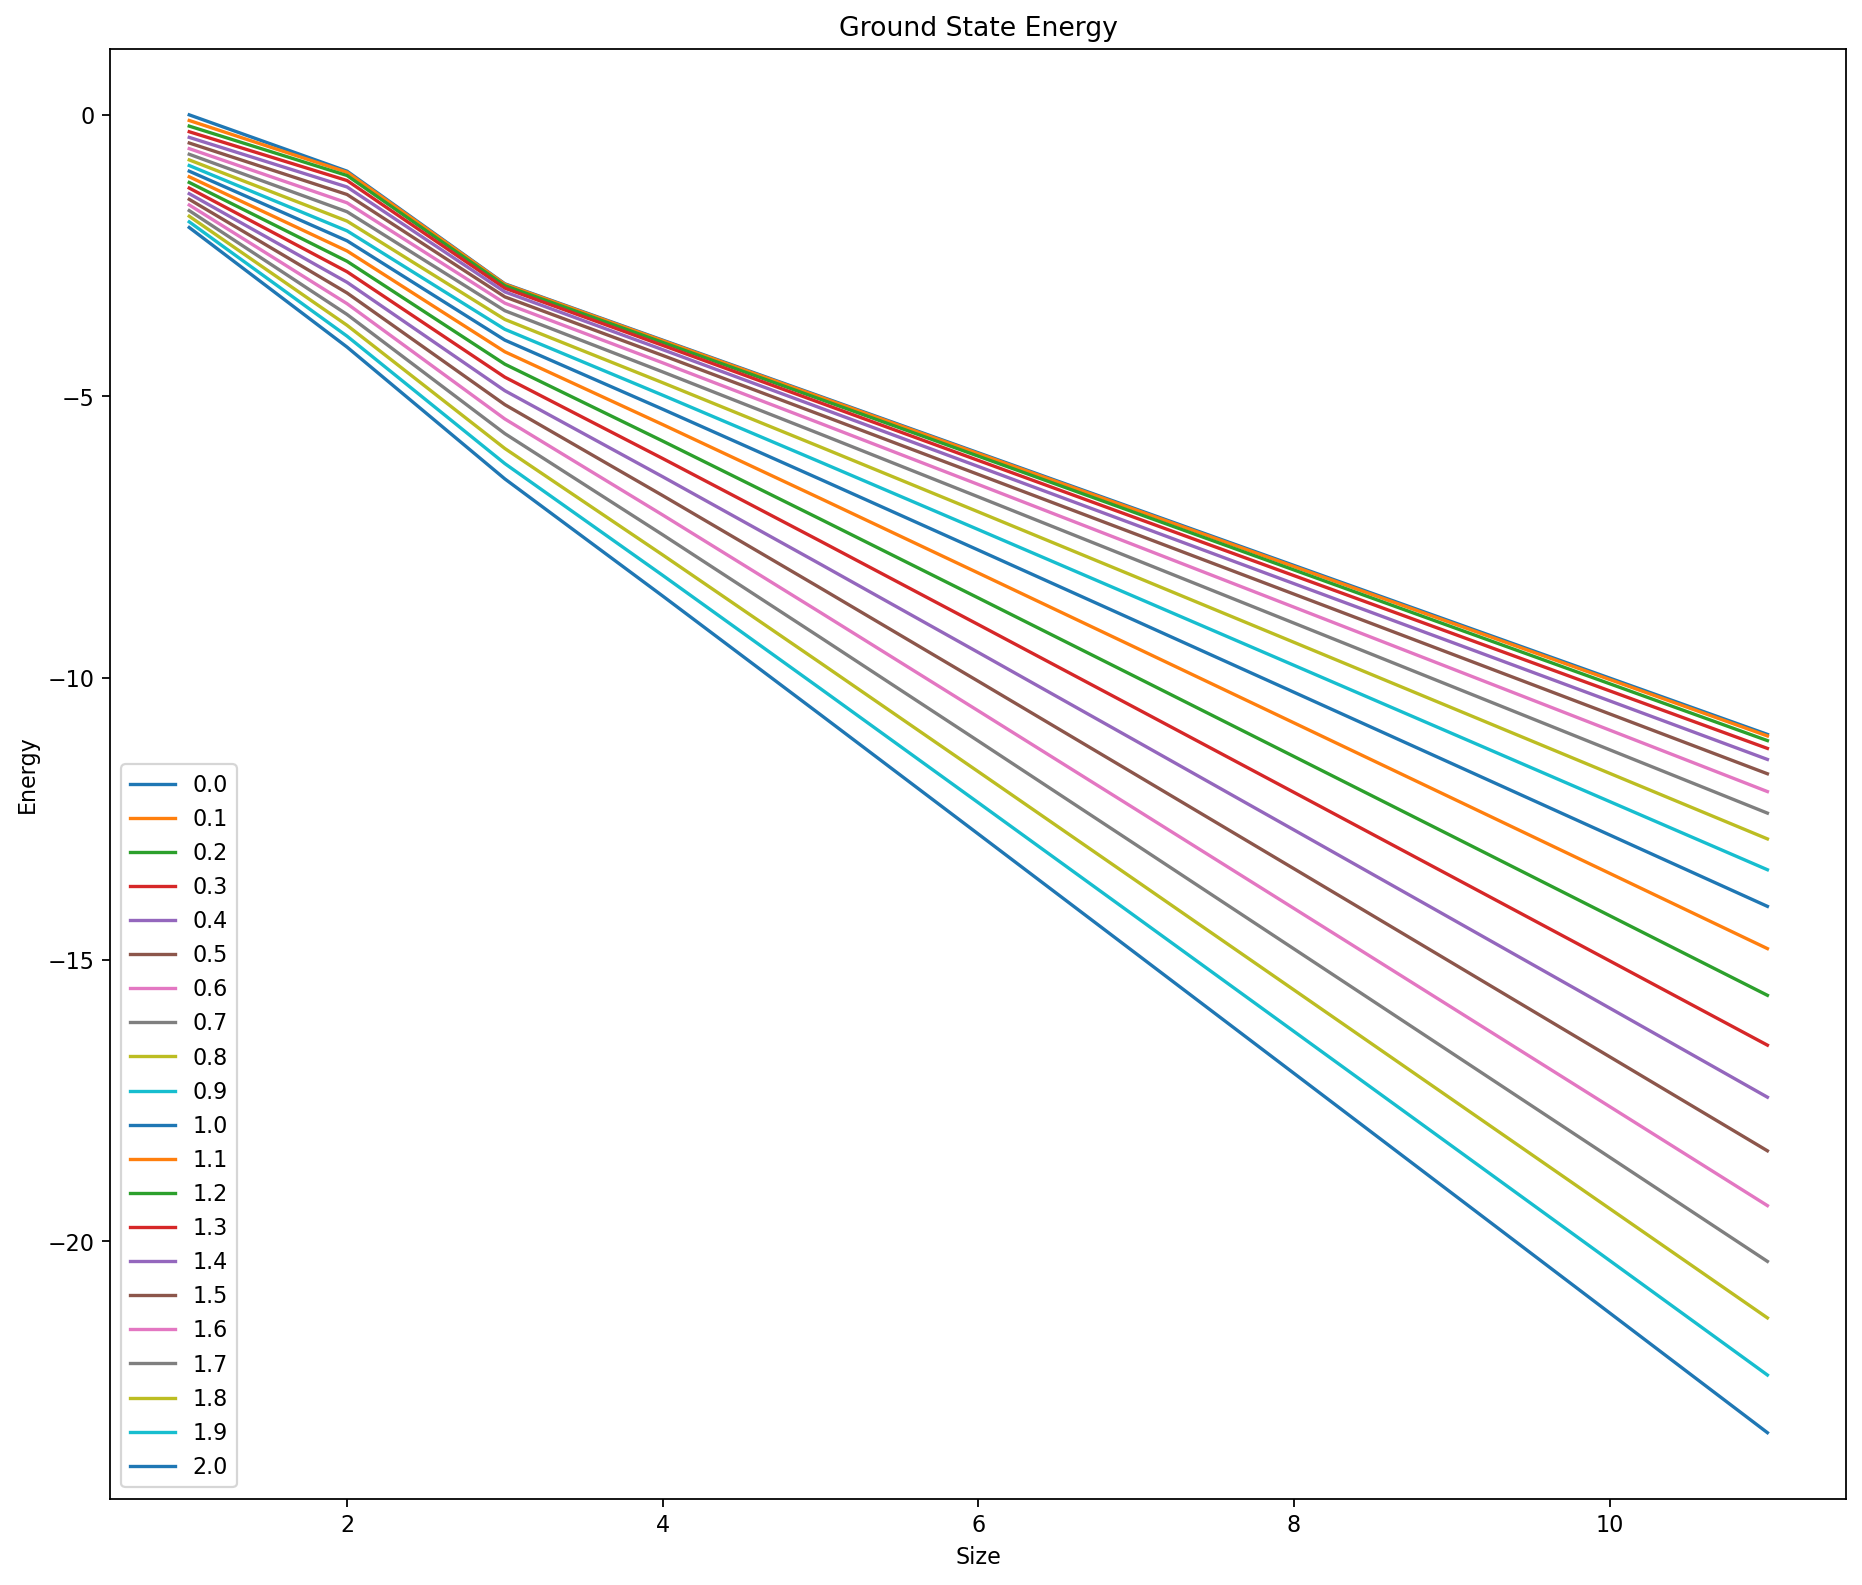

In [13]:
figure(figsize=(14, 12), dpi=160)

for i in range(s//2,s):
    pylab.plot(list(range(1, len(trueGroundStates[i]))), np.asarray(np.real(trueGroundStates[i][1:]), float), label=str(samples[i]))
pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

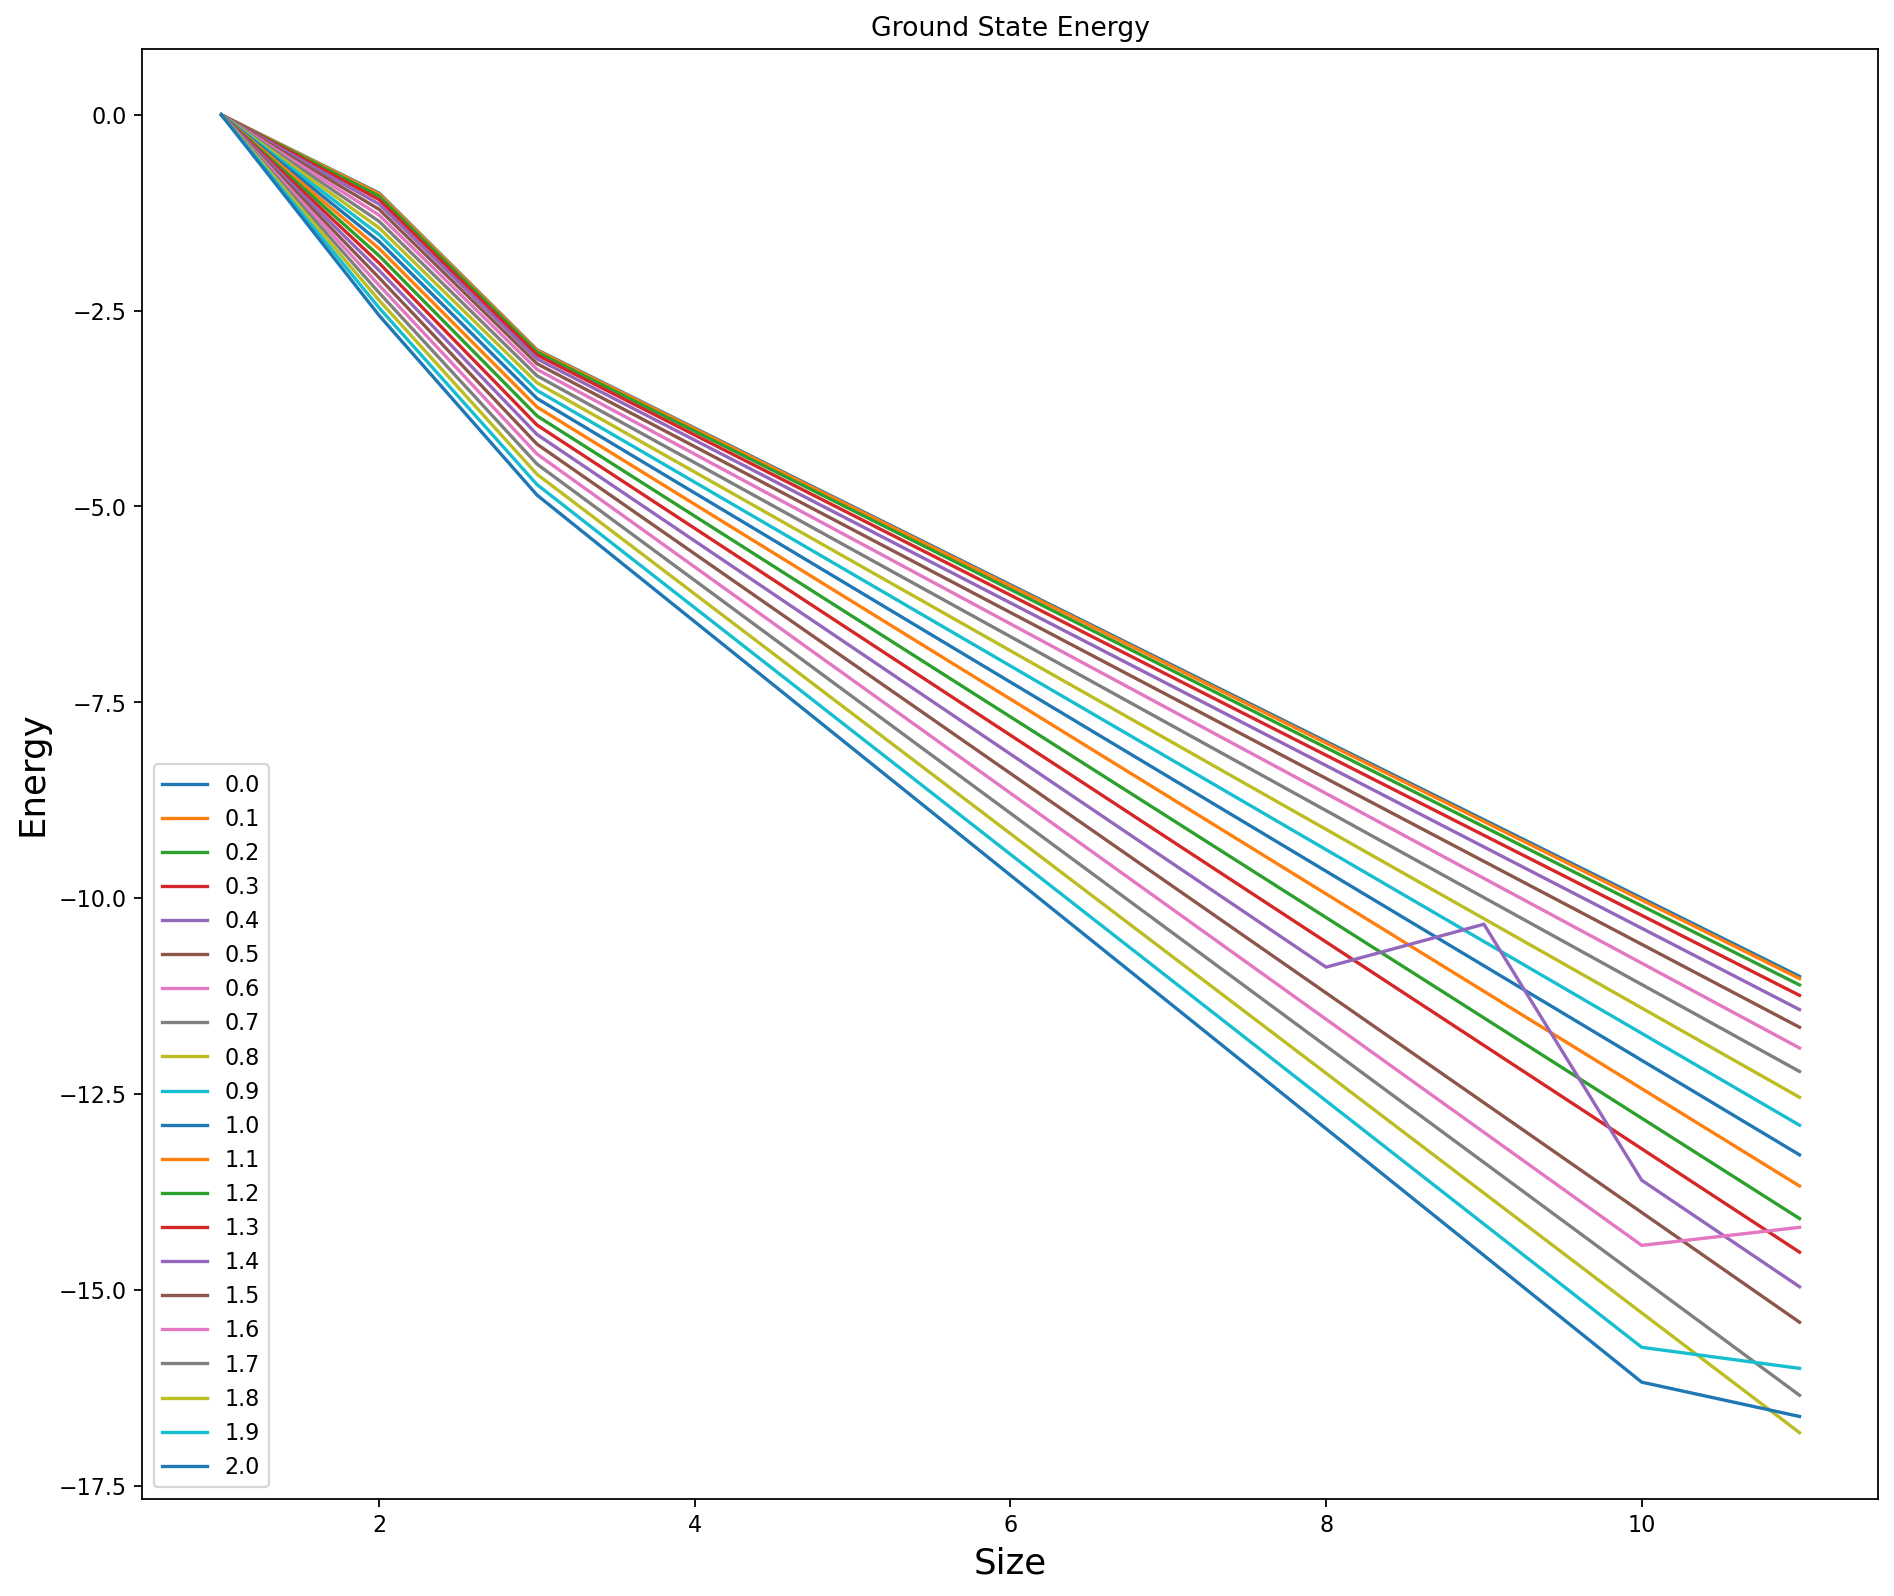

In [16]:
figure(figsize=(14, 12), dpi=160)

for i in range(s//2,s):
    pylab.plot(list(range(1, len(groundStates[i]))), np.asarray(np.real(groundStates[i][1:]), float), label=str(samples[i]))
pylab.xlabel('Size', size = 16)
pylab.ylabel('Energy', size = 16)
pylab.title('Ground State Energy')
pylab.legend(loc='lower left') #more descriptive legend

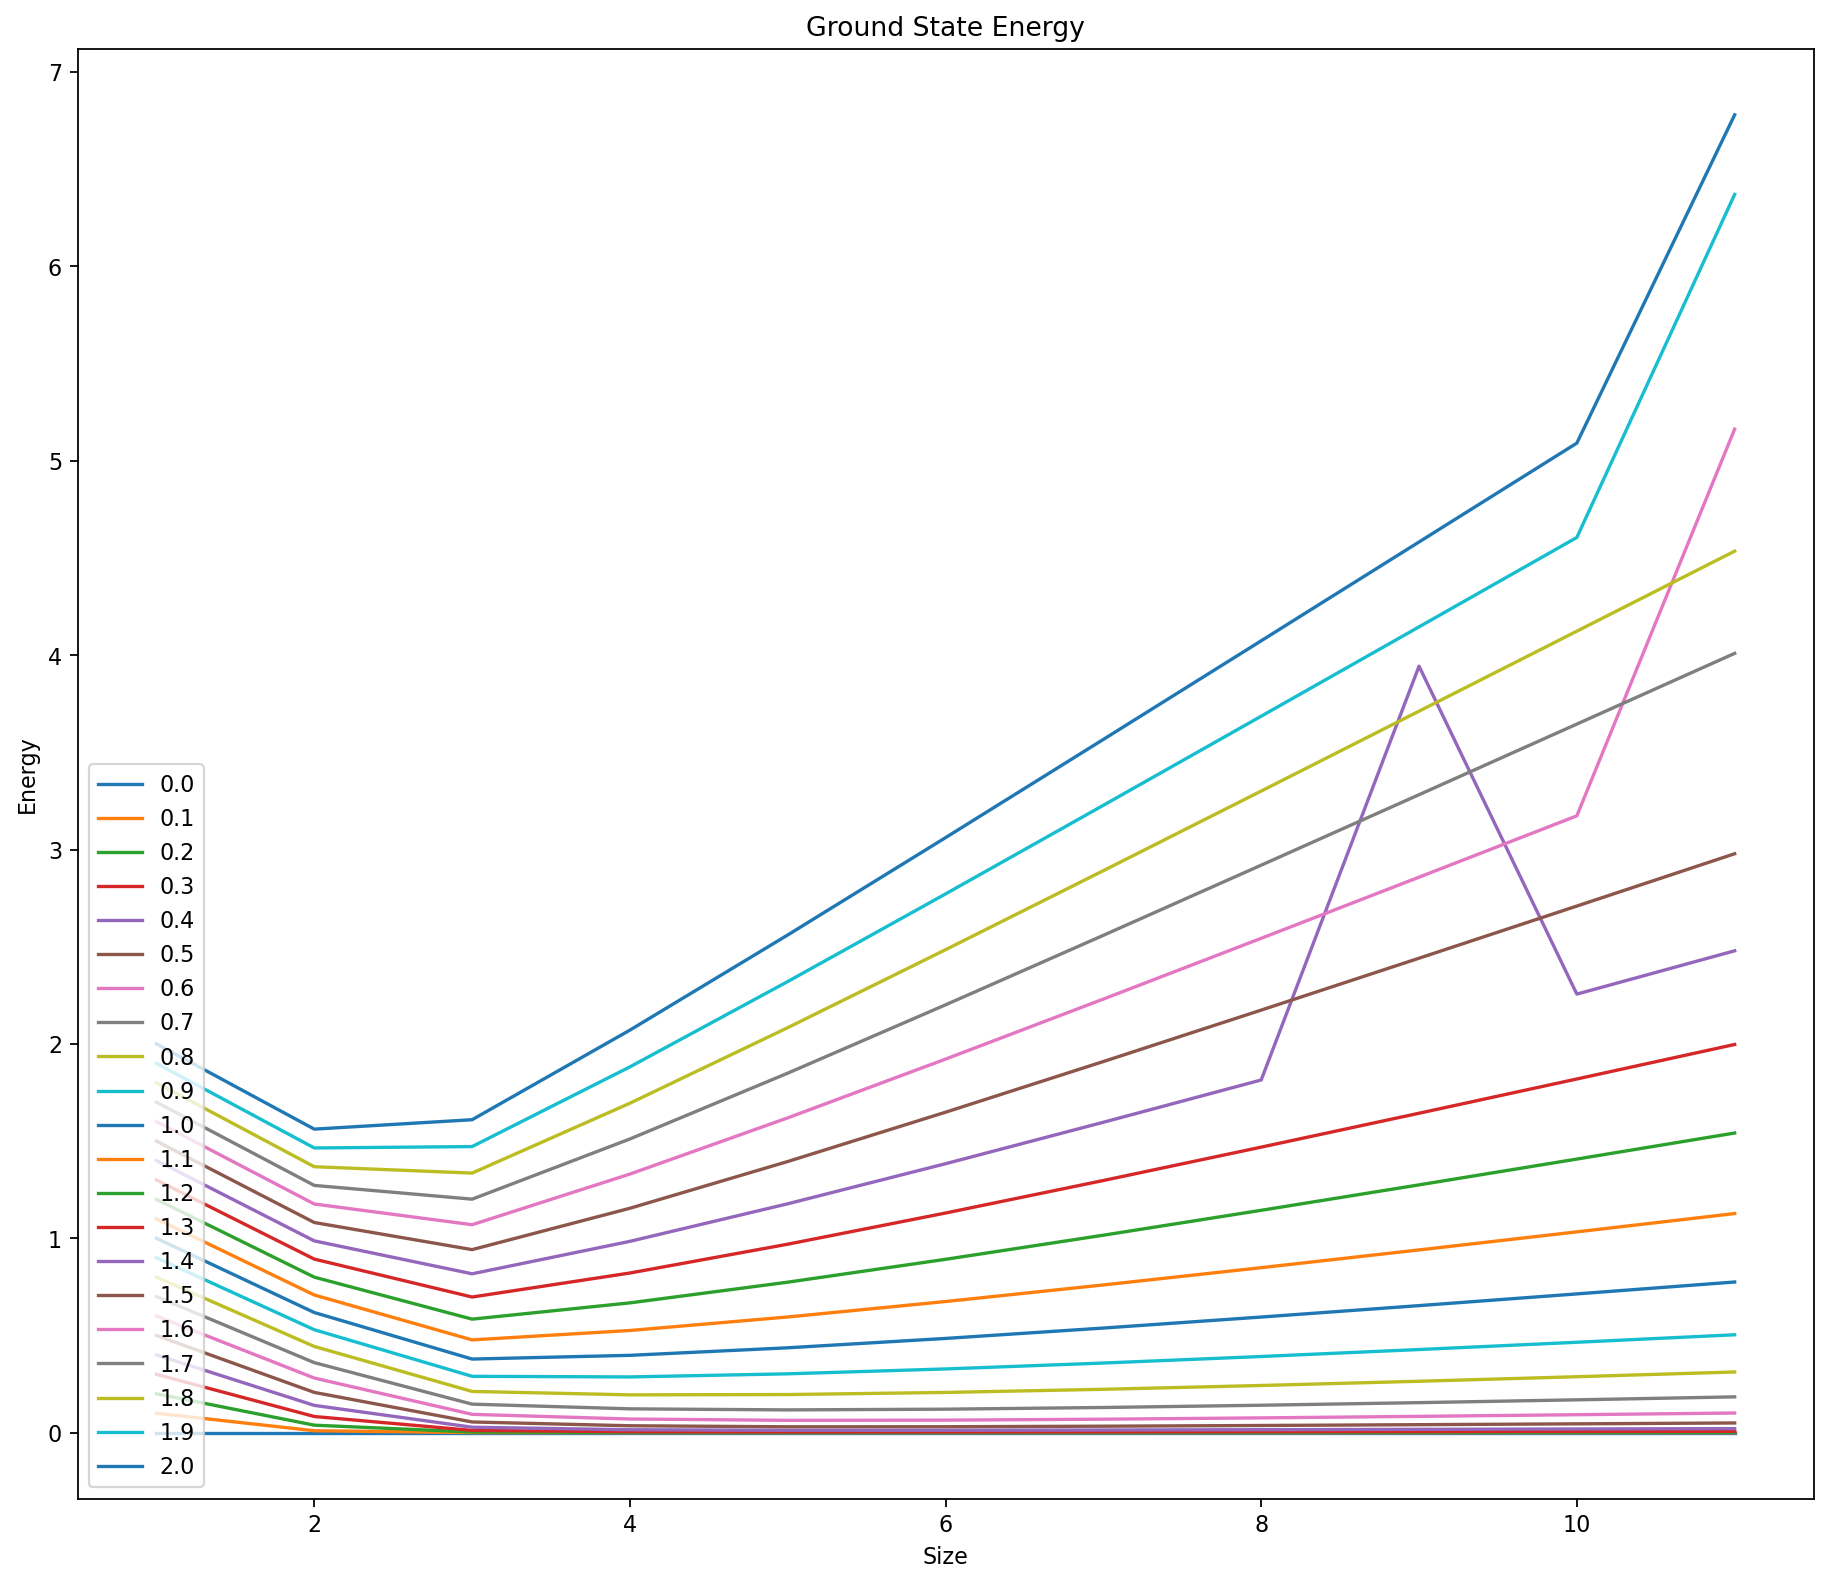

In [17]:
figure(figsize=(14, 12), dpi=160)

for i in range(s//2, s):
    diff = np.asarray(np.real(groundStates[i][1:]), float) - np.asarray(np.real(trueGroundStates[i][1:]), float)
    pylab.plot(list(range(1, len(groundStates[i]))), diff, label=str(samples[i]))
pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

20


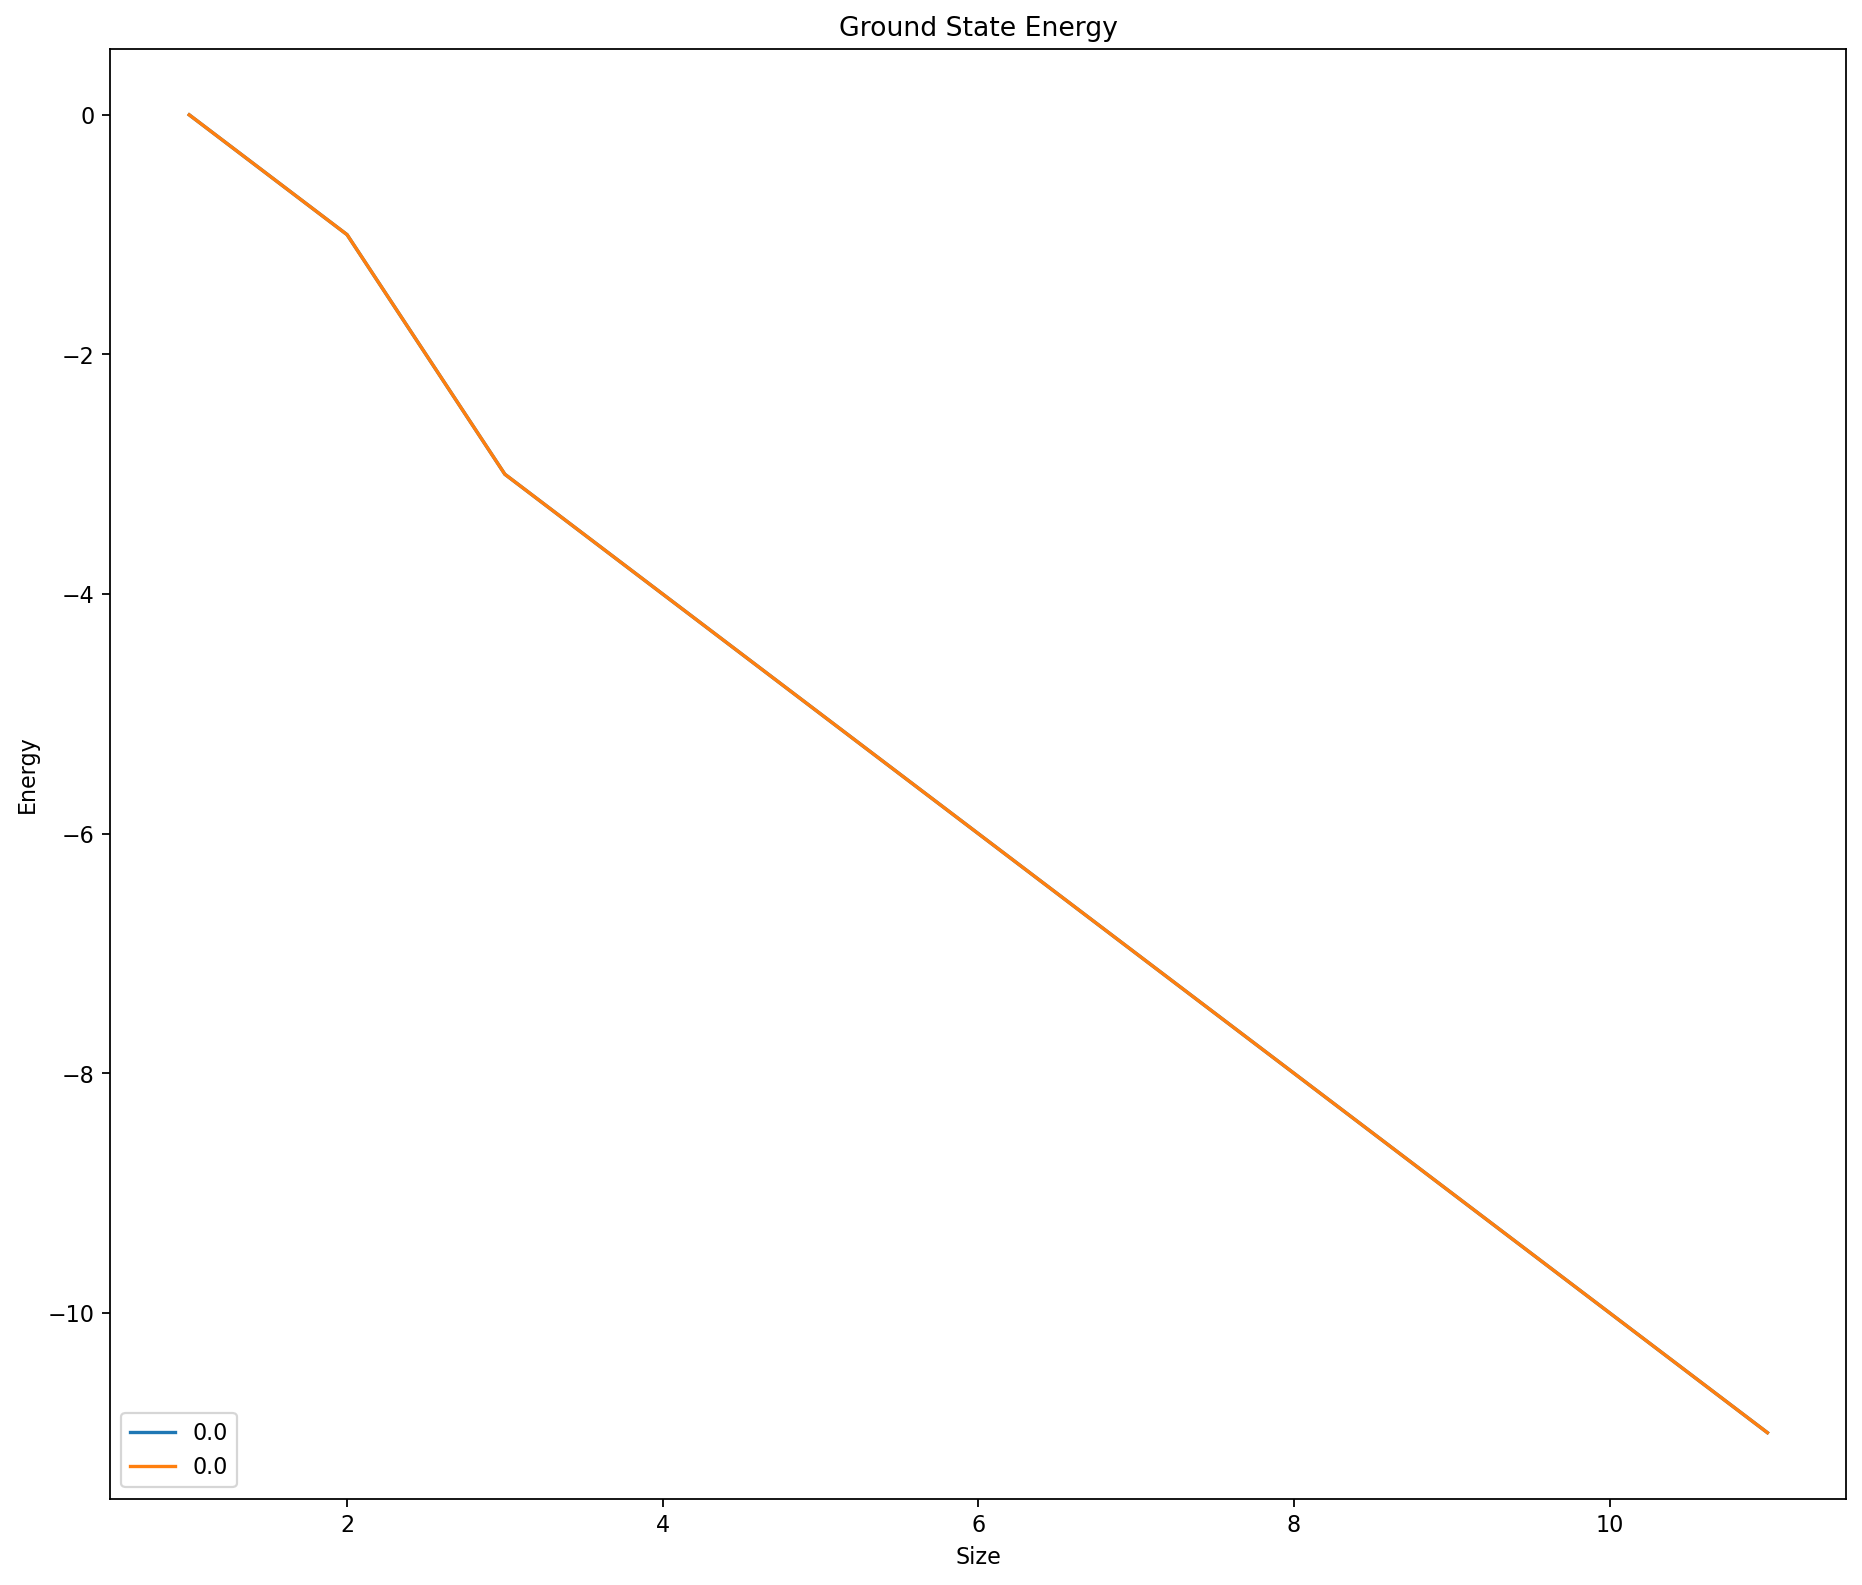

In [24]:
figure(figsize=(14, 12), dpi=160)

for i in range(s//2 , s//2 +1):
    print(i)
    pylab.plot(list(range(1, len(trueGroundStates[i]))), np.asarray(np.real(trueGroundStates[i][1:]), float), label=str(samples[i]))
    pylab.plot(list(range(1, len(groundStates[i]))), np.asarray(np.real(groundStates[i][1:]), float), label=str(samples[i]))
pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

In [92]:
groundStatesArray = np.array(groundStates)
print(np.array(trueGroundStates).shape)
print(groundStatesArray.shape)
print(np.asarray(np.real(groundStatesArray[:, 10]), float).shape)
print(np.asarray(np.real(groundStatesArray[:, 11]), float))
print(np.asarray(np.real(groundStatesArray[i][1:])))

(41, 12)
(41, 12)
(41,)
[-17.79837363 -16.00446378 -16.82519296 -14.79642341 -15.87737912
 -15.41526589 -14.9625573  -14.52067039 -14.09127459 -13.67633534
 -13.27817454 -12.89949303 -12.54343651 -12.2136055  -11.91404667
 -11.64918614 -11.42368076 -11.24216693 -11.10891842 -11.02741384
 -10.99999996 -11.0274219  -11.10891783 -11.24216521 -11.42368109
 -11.64918663 -11.91404657 -12.21360539 -12.5434364  -12.89948663
 -13.27817052 -13.67633184 -14.09127459 -14.52067058 -14.96255767
 -15.41526597 -14.20383604 -16.34769541 -16.82519297 -16.00446426
 -16.61853469]
[  0.          -1.52956301  -3.51804359  -4.69072481  -5.86340595
  -7.03608721  -8.20876841  -9.38144865 -10.5541306  -11.72681187
 -12.89949303]


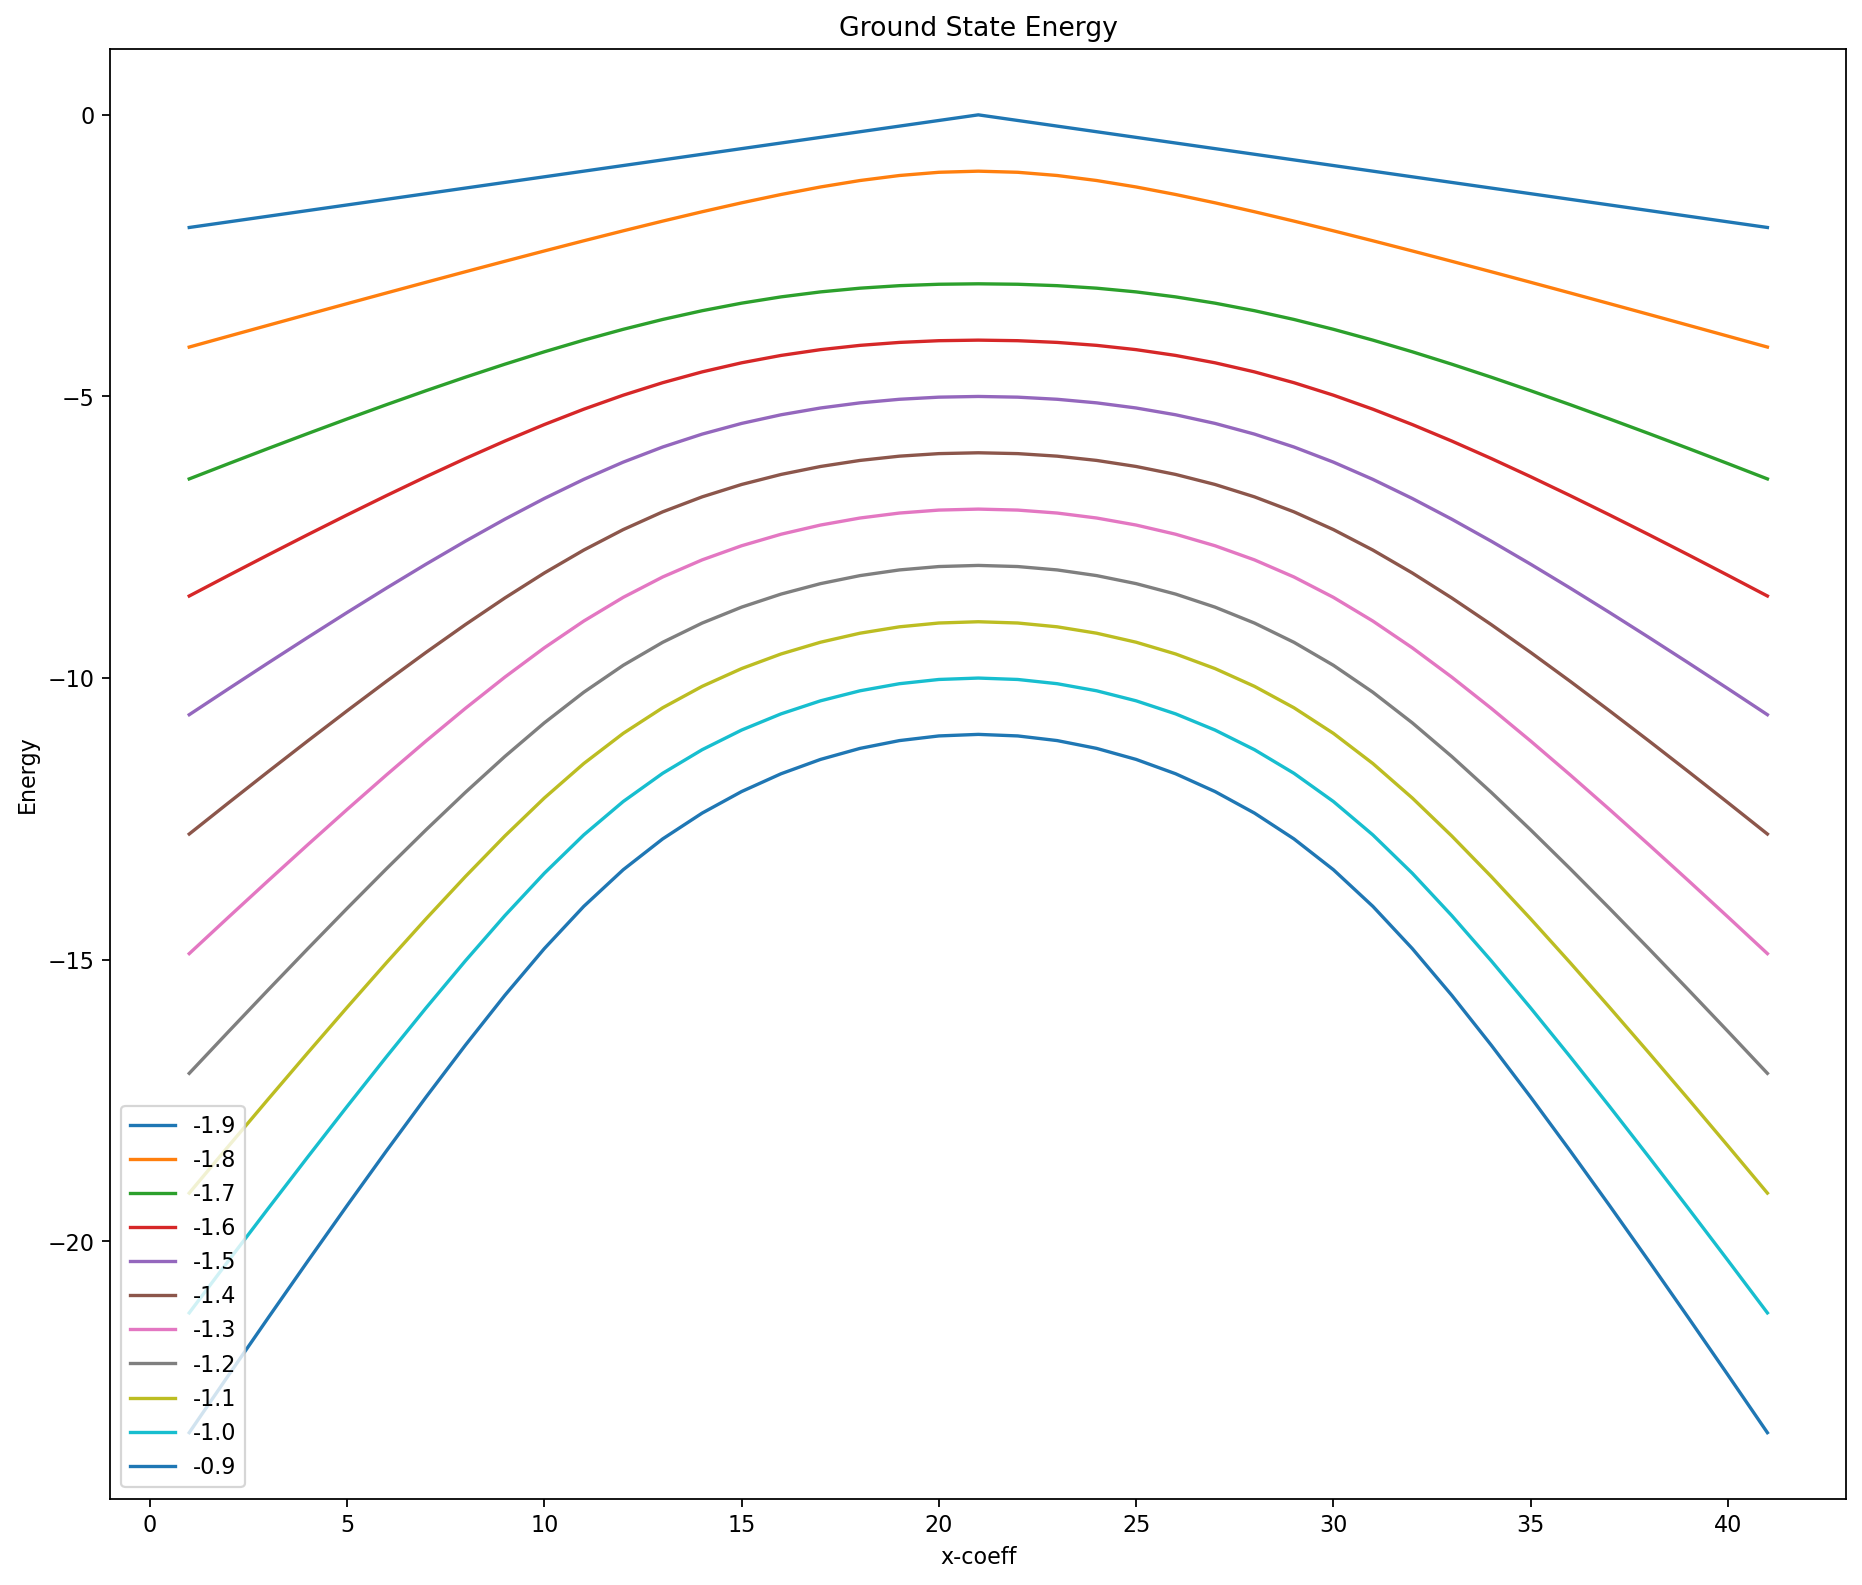

In [80]:
figure(figsize=(14, 12), dpi=160)

for i in range(1,12):
    pylab.plot(list(range(1, 42)), np.asarray(np.real(trueGroundStates[:, i])), label=str(samples[i]))
                                              
pylab.xlabel('x-coeff')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

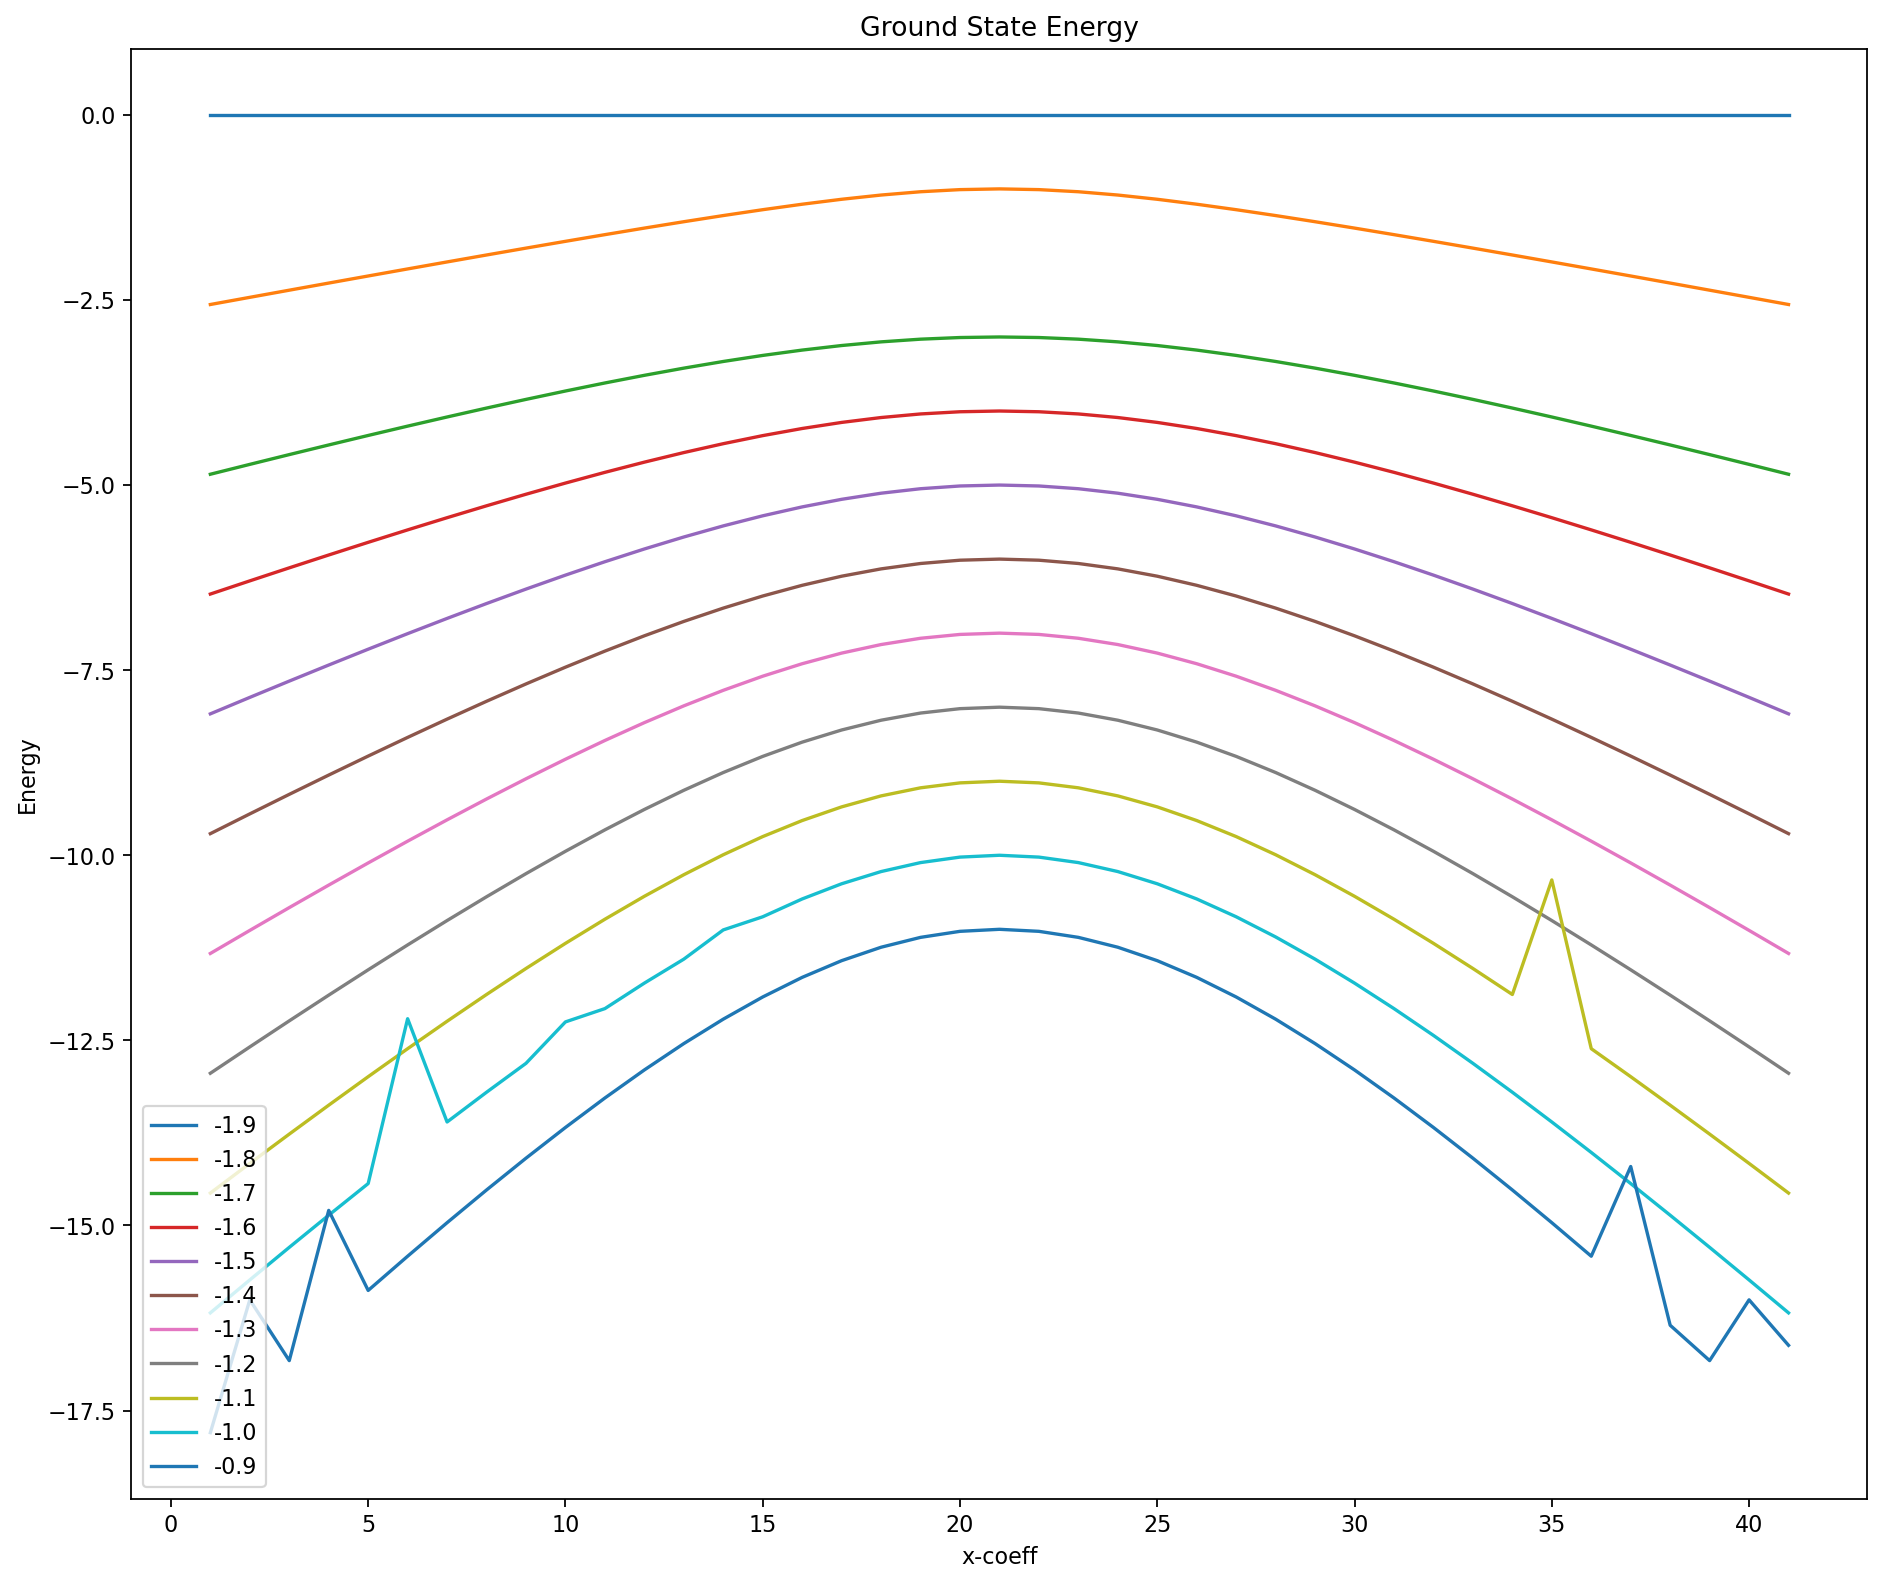

In [93]:
figure(figsize=(14, 12), dpi=160)

for i in range(1,12):
    pylab.plot(list(range(1, 42)), np.asarray(np.real(groundStatesArray[:, i])), label=str(samples[i]))
                                              
pylab.xlabel('x-coeff')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

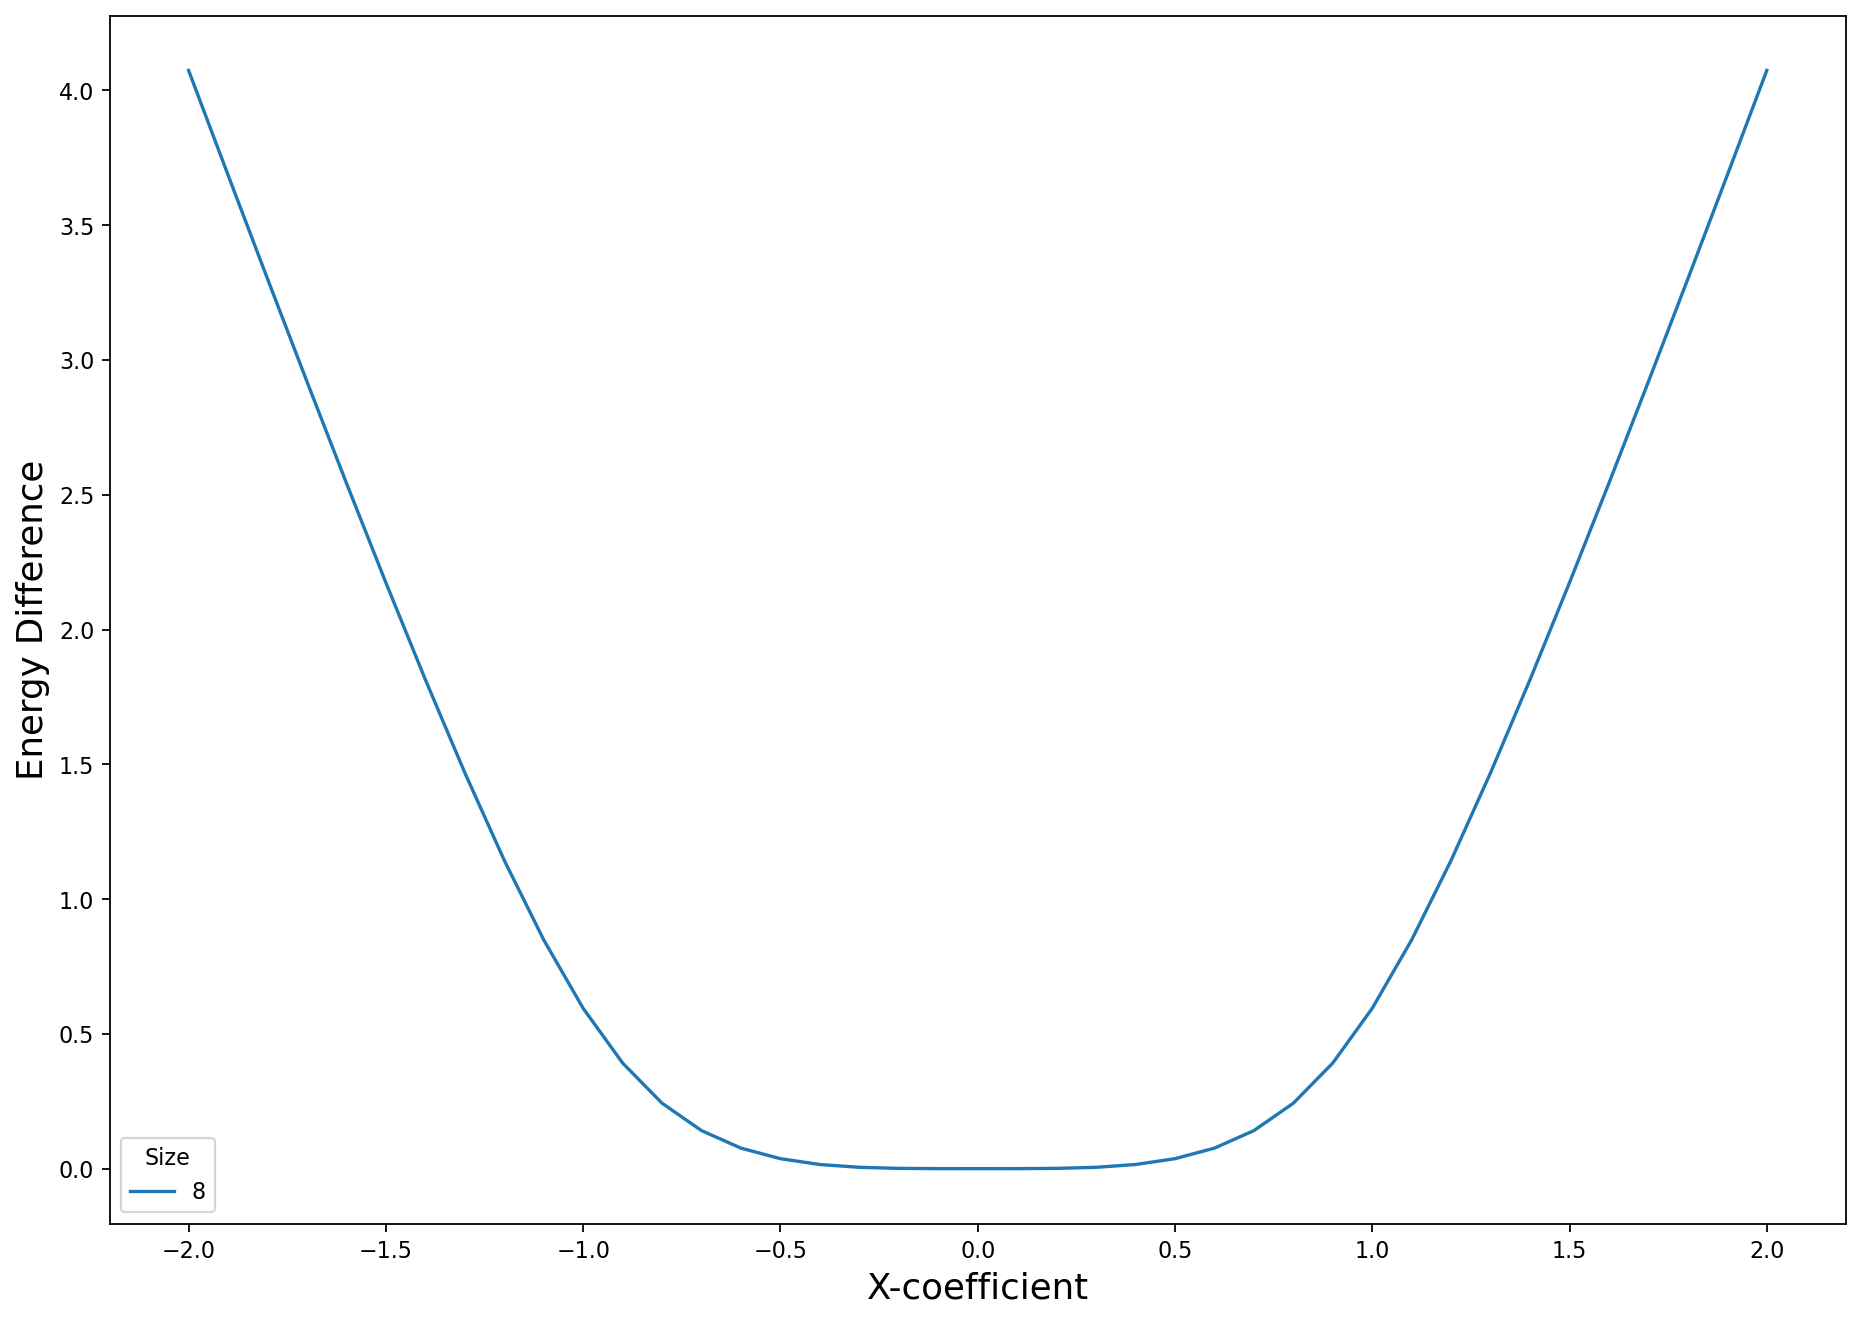

In [127]:
figure(figsize=(14, 10), dpi=160)

for i in range(8,9):
    diff = np.asarray(np.real(np.array(groundStates)[:, i])) - np.asarray(np.real(trueGroundStates[:, i]))
    pylab.plot(samples, diff, label=f"{i}")
                                              
pylab.xlabel('X-coefficient', size = 16)
pylab.ylabel('Energy Difference', size = 16)
pylab.legend(loc='lower left', title = 'Size')
pylab.savefig('plt1.png')

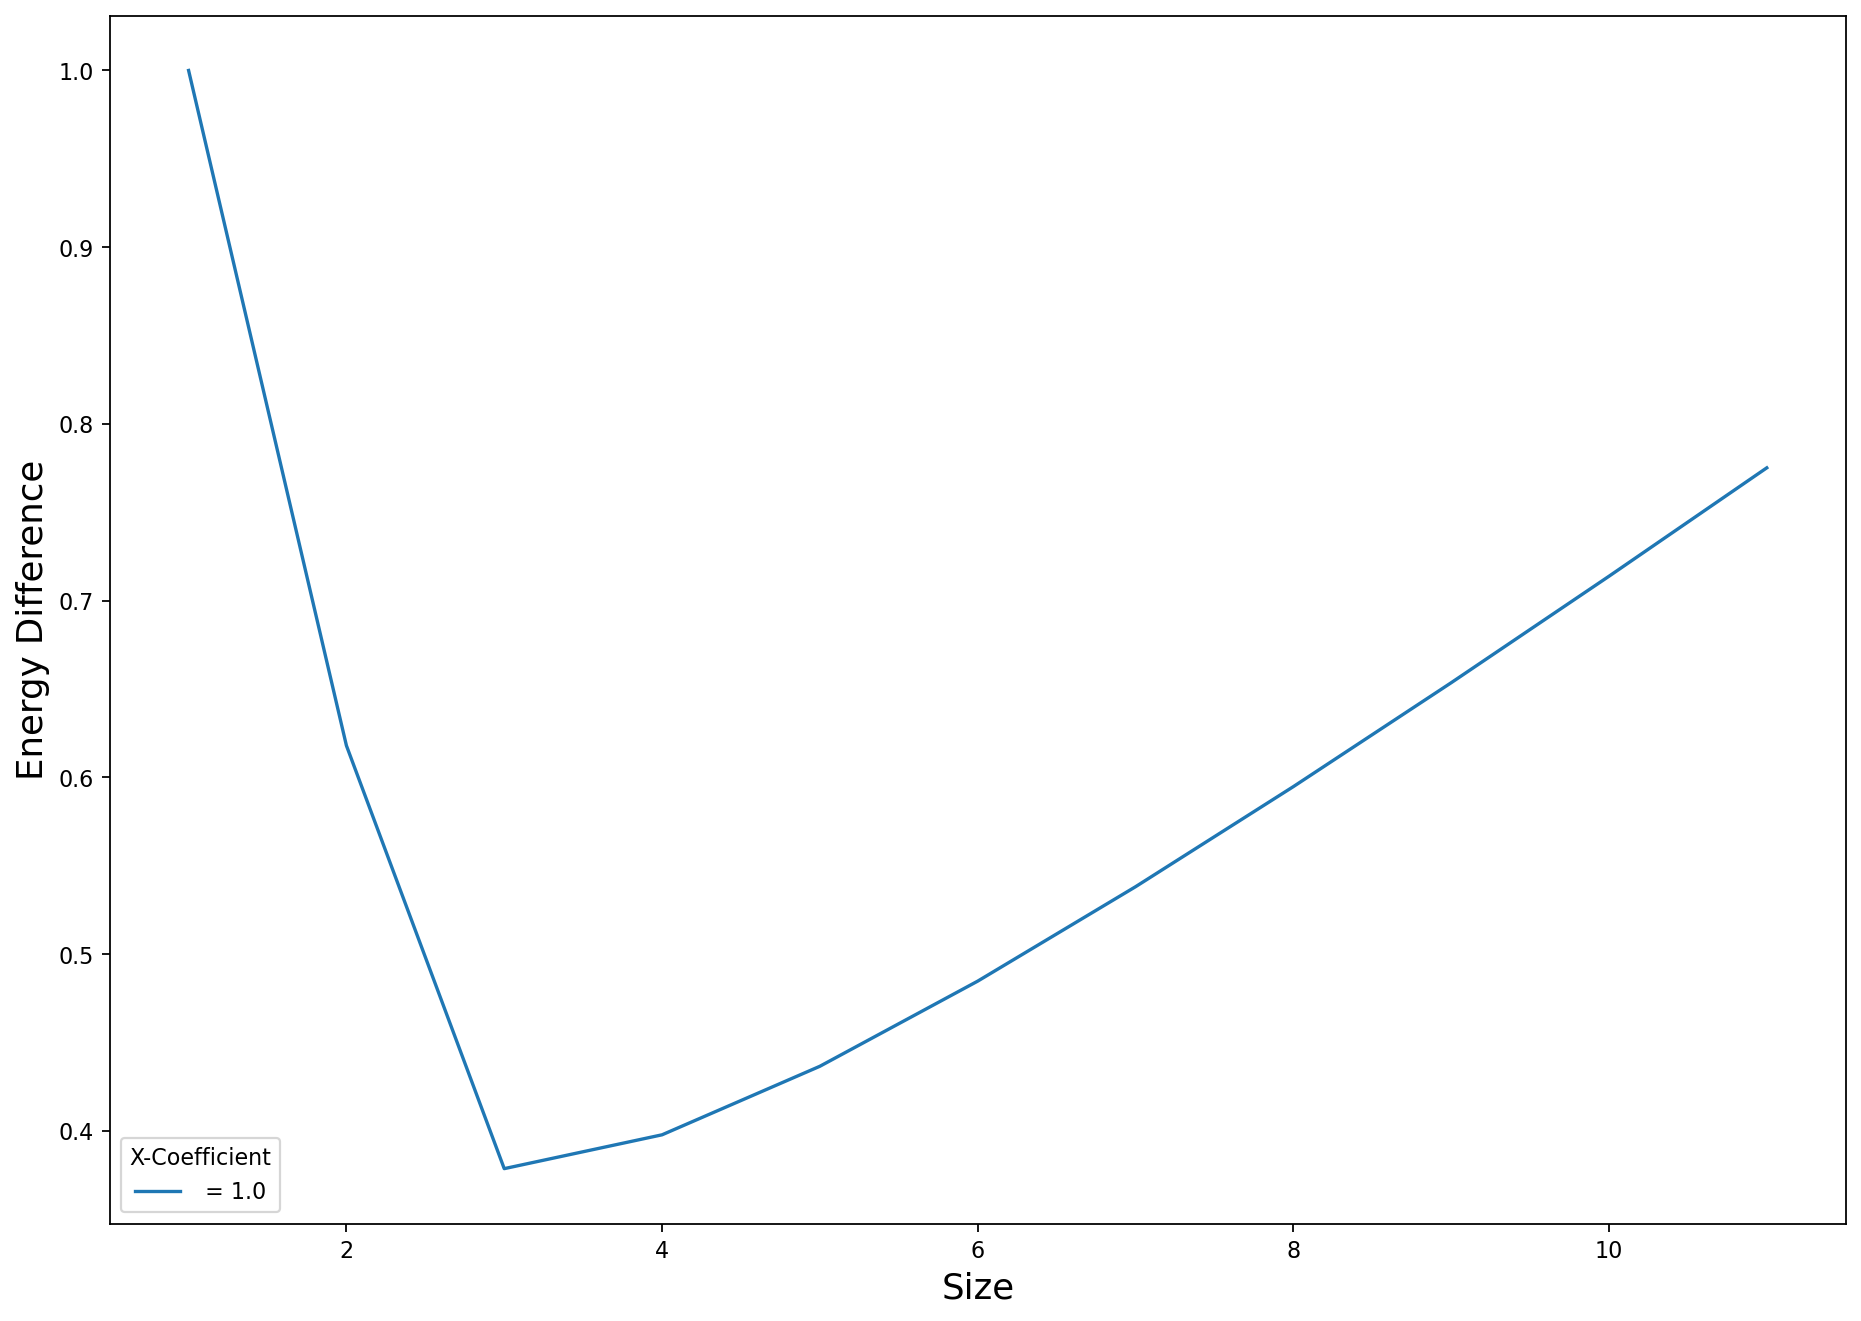

In [126]:
figure(figsize=(14, 10), dpi=160)

for i in range(s//2 + 10, s//2 + 11):
    diff = np.asarray(np.real(groundStates[i][1:]), float) - np.asarray(np.real(trueGroundStates[i][1:]), float)
    pylab.plot(list(range(1, len(groundStates[i]))), diff, label=f" = {samples[i]}")
pylab.xlabel('Size', size = 16)
pylab.ylabel('Energy Difference', size = 16)
pylab.legend(loc='lower left', title='X-Coefficient')
pylab.savefig('plt3.png')

In [25]:
print(groundStates)

[array([ 9.99990000e+03,  0.00000000e+00, -2.56155281e+00, -4.85410196e+00,
       -6.47213595e+00, -8.09016991e+00, -9.70820388e+00, -1.13262379e+01,
       -1.29442718e+01, -1.45623057e+01, -1.61803398e+01, -1.77983736e+01]), array([ 9.99990000e+03,  0.00000000e+00, -2.46468827e+00, -4.72063656e+00,
       -6.29418208e+00, -7.86772762e+00, -9.44127312e+00, -1.10148187e+01,
       -1.25883641e+01, -1.41619097e+01, -1.57354551e+01, -1.60044638e+01]), array([ 9.99990000e+03,  0.00000000e+00, -2.36815417e+00, -4.58868900e+00,
       -6.11825204e+00, -7.64781506e+00, -9.17737806e+00, -1.07069410e+01,
       -1.22365040e+01, -1.37660666e+01, -1.52956299e+01, -1.68251930e+01]), array([ 9.99990000e+03,  0.00000000e+00, -2.27200451e+00, -4.45846244e+00,
       -5.94461658e+00, -7.43077070e+00, -8.91692478e+00, -1.04030790e+01,
       -1.18892330e+01, -1.33753873e+01, -1.48615412e+01, -1.47964234e+01]), array([ 9.99990000e+03,  0.00000000e+00, -2.17630546e+00, -4.33019433e+00,
       -5.773592